# CS598 Deep Learning for Healthcare Reproducibility Project
Esther Tang
(esthert2@illinois.edu)

The paper I attempted to reproduce was [_Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness_](https://proceedings.mlr.press/v193/jeanselme22a/jeanselme22a.pdf) by Jeanselme et al. (2022)$^{[1]}$. This paper studies the impact of using imputation to fill in missing data.

Because the data used in deep learning for healthcare comes from patients interacting with the healthcare system, inequitable patterns in these interactions translate to inequitable patterns in healthcare data. If we train machine learning models on this data, we could be further cementing some of these patterns of inequities in our healthcare systems.

The authors suggest 3 possible causes of data missingness: 
1. Limited access to healthcare, often due to structural inequalities.
2. Mis-informed data collection, where patients in certain groups may not display “textbook” symptoms and, therefore, may not be tested for a disease.
3. Confirmation bias is involved, as practitioners have been shown to only collect data or order labs when they think a patient is ill.

Researchers will often fill in missing data using imputation, but the impacts of this are understudied and overlooked. This paper attempts to help analyze the effects that different imputation strategies have on marginalized populations.

### Prepare the data
The authors use both synthetic & MIMIC-III$^{[2]}$ data, but I focused on the MIMIC-III dataset in my project. 

Lab, patient, and admissions data from the MIMIC-III dataset are used to verify the paper’s results. The data is harmonized using MIMIC-Extract$^{[3]}$, and only adult patients surviving at least 24 hours are selected. This leaves us with a dataset consisting of 36,295 patients and 67 potential lab test results for each patient. 

First, obtain the ADMISSIONS.csv, LABEVENTS.csv, and PATIENTS.csv files from the [MIMIC-III dataset](https://physionet.org/content/mimiciii/1.4/) and place them in the MimicData folder. 

Add the itemid_to_variable_map.csv file from [MIMIC-Extract](https://github.com/MLforHealth/MIMIC_Extract/blob/master/resources/itemid_to_variable_map.csv) to the MimicData folder.

Then, run the code below to preprocess the data.

In [1]:
# Import libraries
import io
from contextlib import redirect_stdout
import pandas as pd
from Experiment import experiment
from Analysis import *
# Set plot defaults
sns.set_theme(style = "darkgrid", font_scale = 1, rc = {'figure.dpi':300, 'savefig.dpi':300})

In [2]:
# Run the preprocessing script
with redirect_stdout(io.StringIO()):
    !python Preprocessing.py

In [3]:
# Get preprocessed data
PREPROCESSED_DATA_PATH = './PreprocessedData/'
labs = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labs.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labeled_outcomes.csv', index_col = 0)

demographics = {
    'GENDER': {'data': outcomes['GENDER'], 'populations': ['Female', 'Male']}, 
    'ETHNICITY': {'data': outcomes['ETHNICITY'], 'populations': ['Black', 'Non Black']}, 
    'INSURANCE': {'data': outcomes['INSURANCE'], 'populations': ['Public', 'Private']}, 
    'Outcome': {'data': outcomes['Outcome'], 'populations': ['Death', 'Alive']}
}

dataset_stats = getDatasetStatistics(labs, outcomes, demographics)
pd.set_option('display.precision', 1)
display(dataset_stats)

# of Patients  Avg # Lab Events  Avg # Lab Tests
Overall   All Patients          36295               5.8             54.4
GENDER    Male                  20592               6.1             56.0
          Female                15703               5.5             52.3
ETHNICITY Non Black             33515               5.9             54.8
          Black                  2780               5.1             49.5
INSURANCE Private               12136               6.2             57.0
          Public                24159               5.7             53.1
Outcome   Alive                 33858               5.7             53.5
          Death                  2437               7.3             66.7

### Run the experiment
Four data imputation strategies are applied to the processed data: 
1. Simple Median Imputation
2. MICE 
3. Group MICE
4. Group MICE Missing 

The paper examines how these four imputation methods impact the performance of a logistic regression model$^{[4]}$ as it predicts short-term survival for the entire population and for marginalized groups.

Run the following code to:
1. apply the four imputation methods
2. use the logistic regression to generate predictions for the survival of each patient in the processed dataset

##### Notes: 
Running this code may take 3+ hours to complete. To shorten the run time:
- reduce the # of iterations for each imputation strategy in the `imputation_iterations` parameter
- select just one `C` value in the `hyperparameters` to avoid doing the hyperparameter search

Additional experiments:
- To remove regularization, call the `experiment` method with `regularization = False`
- To use the MLP Classifier in lieu of the logistic regression model, call the `experiment` method with `model_name = 'mlp_classifier'`

In [ ]:
# Select model parameters and run experiment
imputation_iterations = { # Choose fewer iterations to reduce run time
    'Median': 100,
    'MICE': 10,
    'Group MICE': 10,
    'Group MICE Missing': 10
}
hyperparameters = {
    'logistic_regression': {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1., 10], # Choose only 1 C value to reduce run time
        'solver': ['sag'], 
        'max_iter': [1000],
        'n_jobs': [-1]
    },
    'mlp_classifier': {
        'hidden_layer_sizes': [(5, 2)],
        'activation': ['logistic'],
        'solver': ['adam'], 
        'max_iter': [1000]
    }
}
# To remove regularization, call experiment method with regularization = False
# To test MLP Classifier, call experiment method with model_name = 'mlp_classifier'
experiment(imputation_iterations, hyperparameters, regularization = True, model_name = 'logistic_regression')

### Analyze the results
Using the predictions generated by the Experiment.py script, we can now examine the impact of each imputation method on the logistic regression's ability to predict outcomes for the overall population as well as for each demographic group.

Run the code below to obtain the experiment results and to generate the AUC ROC, Prioritization Percentage, and False Negative Rate (FNR).

In [3]:
# Get experiment results
labs, outcomes, predictions, demographics = getExperimentResults()

# Get calculated metrics
all_average_metrics, all_gap_metrics = getAllMetrics(demographics, outcomes, predictions)

#### Overall Results
These are all the results obtained from running the reproducibility experiment. Results can be compared against the original paper's results.

The exact results generated by my code differed slightly from those in the original paper. This is due to randomness introduced by the linear regression model in the MICE-related strategies, as well as to a few errors in the original paper's code, including: 
- Incorrect Age calculation 
- Inconsistent labeling of minority groups
- Ethnicity data used to generate gender label

The table and graphs below represent the average AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each demographic group.

Average AUC ROC


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.818  0.793       0.789               0.813
            Non Black    0.741  0.734       0.738               0.784
GENDER      Female       0.735  0.727       0.733               0.779
            Male         0.755  0.745       0.745               0.792
INSURANCE   Public       0.741  0.731       0.735               0.777
            Private      0.726  0.728       0.725               0.786
OVERALL     Overall      0.746  0.738       0.742               0.787

Average Prioritized Percentage


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.353  0.328       0.204               0.209
            Non Black    0.295  0.297       0.307               0.308
GENDER      Female       0.324  0.326       0.362               0.357
            Male         0.281  0.279       0.251               0.256
INSURANCE   Public       0.351  0.346       0.390               0.370
            Private      0.196  0.208       0.120               0.159
OVERALL     Overall      0.300  0.300       0.300               0.300

Average Wrongly not prioritized (FNR)


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.192  0.264       0.375               0.435
            Non Black    0.366  0.374       0.360               0.299
GENDER      Female       0.370  0.373       0.331               0.265
            Male         0.335  0.359       0.390               0.347
INSURANCE   Public       0.320  0.331       0.299               0.255
            Private      0.486  0.492       0.592               0.497
OVERALL     Overall      0.353  0.365       0.364               0.305

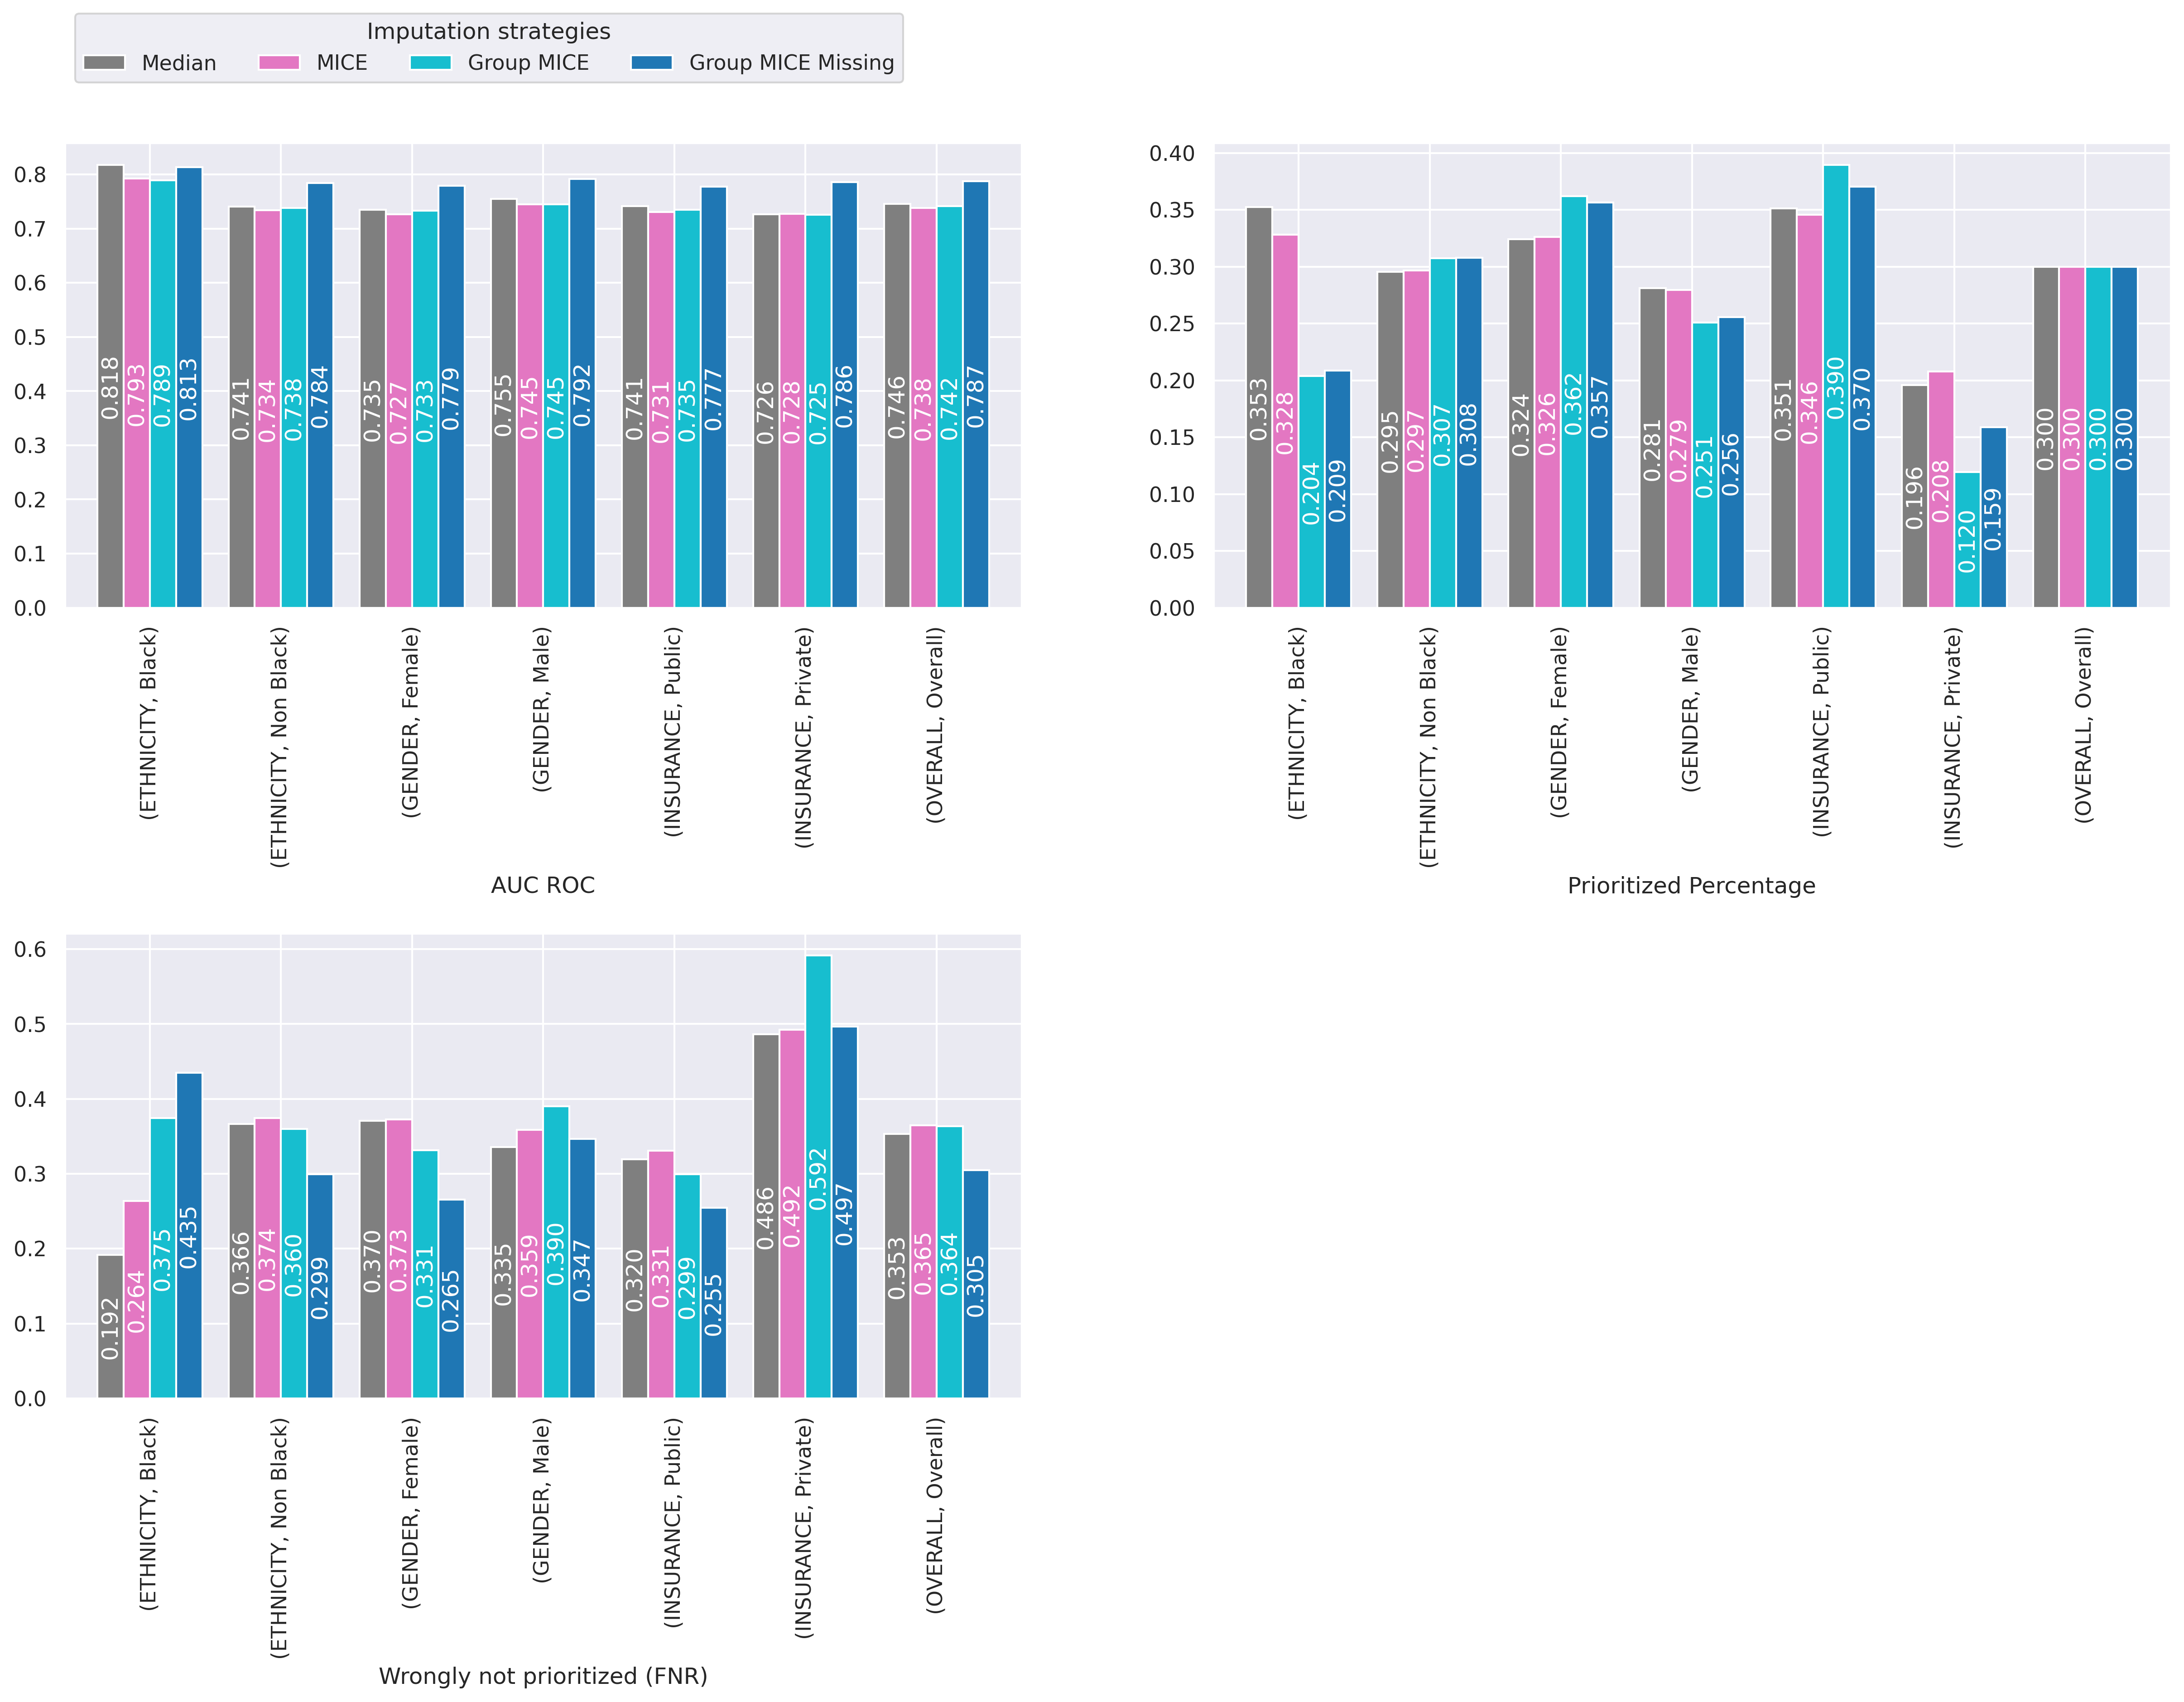

In [4]:
pd.set_option('display.precision', 3)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

axes = [ax1, ax2, ax3]
metric_list = ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)']
for i in range(len(axes)):
    showLegend = True
    if i > 0:
        showLegend = False
    data, _ = displayPopulationMetrics(metric_list[i], all_average_metrics, ax = axes[i], showLegend = showLegend)
    print("Average", metric_list[i])
    display(data)

ax4.axis('off')
fig.subplots_adjust(hspace = 0.7)
plt.show()

The table and graphs below represent the difference in AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each minority versus majority group. For each strategy, we can see the difference in performance for: 
- Ethnicity (minority = Black, majority = Non Black)
- Gender (minority = Female, majority = Male)
- Insurance (minority = Public, majority = Private)

Minority vs Majority Gap: AUC ROC


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.077,0.059,0.051,0.029
GENDER,-0.020,-0.018,-0.012,-0.013
INSURANCE,0.015,0.003,0.010,-0.009


Minority vs Majority Gap: Prioritized Percentage


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.057,0.031,-0.103,-0.099
GENDER,0.043,0.047,0.111,0.101
INSURANCE,0.155,0.138,0.270,0.211


Minority vs Majority Gap: Wrongly not prioritized (FNR)


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,-0.174,-0.111,0.014,0.136
GENDER,0.035,0.014,-0.059,-0.082
INSURANCE,-0.166,-0.161,-0.292,-0.242


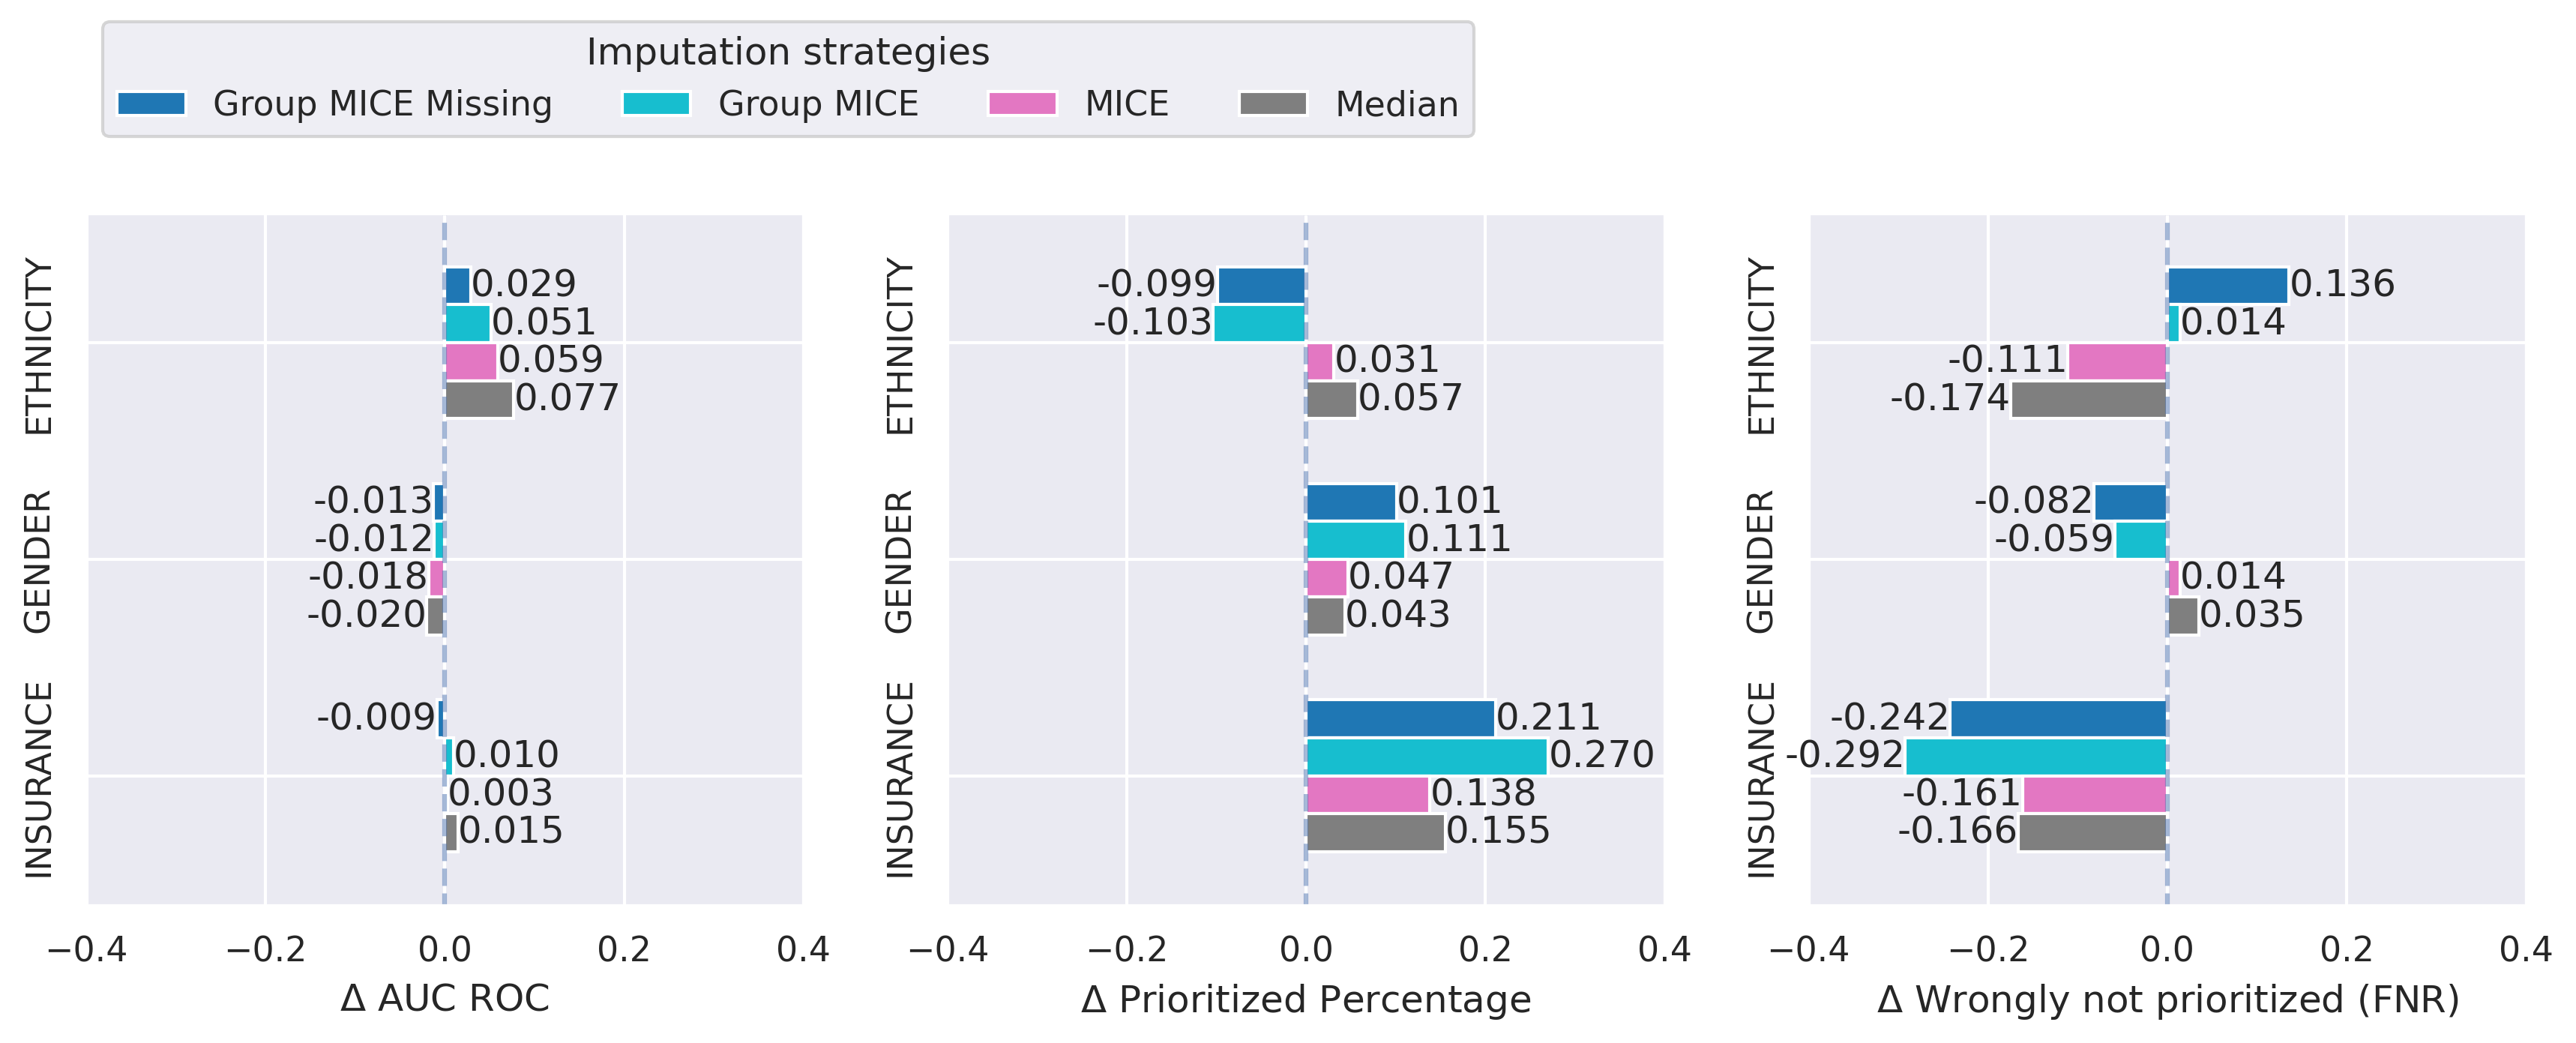

In [5]:
pd.set_option('display.precision', 3)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

axes = [ax1, ax2, ax3]
metric_list = ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)']
for i in range(len(axes)):
    showLegend = True
    if i > 0:
        showLegend = False
    data, _ = displayMinorityMajorityComparison(metric_list[i], all_gap_metrics, ax = axes[i], showLegend = showLegend)
    print("Minority vs Majority Gap:", metric_list[i])
    display(data[['Median', 'MICE', 'Group MICE', 'Group MICE Missing']])
    
plt.show()

#### Verification of Key Claims
Despite some differences in my results compared to the original paper's results, my results still supported the key results from the original paper. 

There are 4 main claims from the paper that I attempted to replicate:
1. Non-random missingness patterns exist in real data.
2. Imputation methods that perform equally at the population level may perform differently for specific groups.
3. There is no one “best” imputation strategy for all populations and all missingness scenarios.
4. Adding covariates or missingness indicators does not always improve performance.

Run the following code to view the results for each claim.

#### Claim 1: Non-random missingness patterns exist in real data.
We see that more lab tests are ordered for patients who end up dying, which provides evidence for a non-random missingness pattern where medical practitioners are more likely to order labs for patients they believe are ill.

We also see that minority groups receive fewer lab tests.

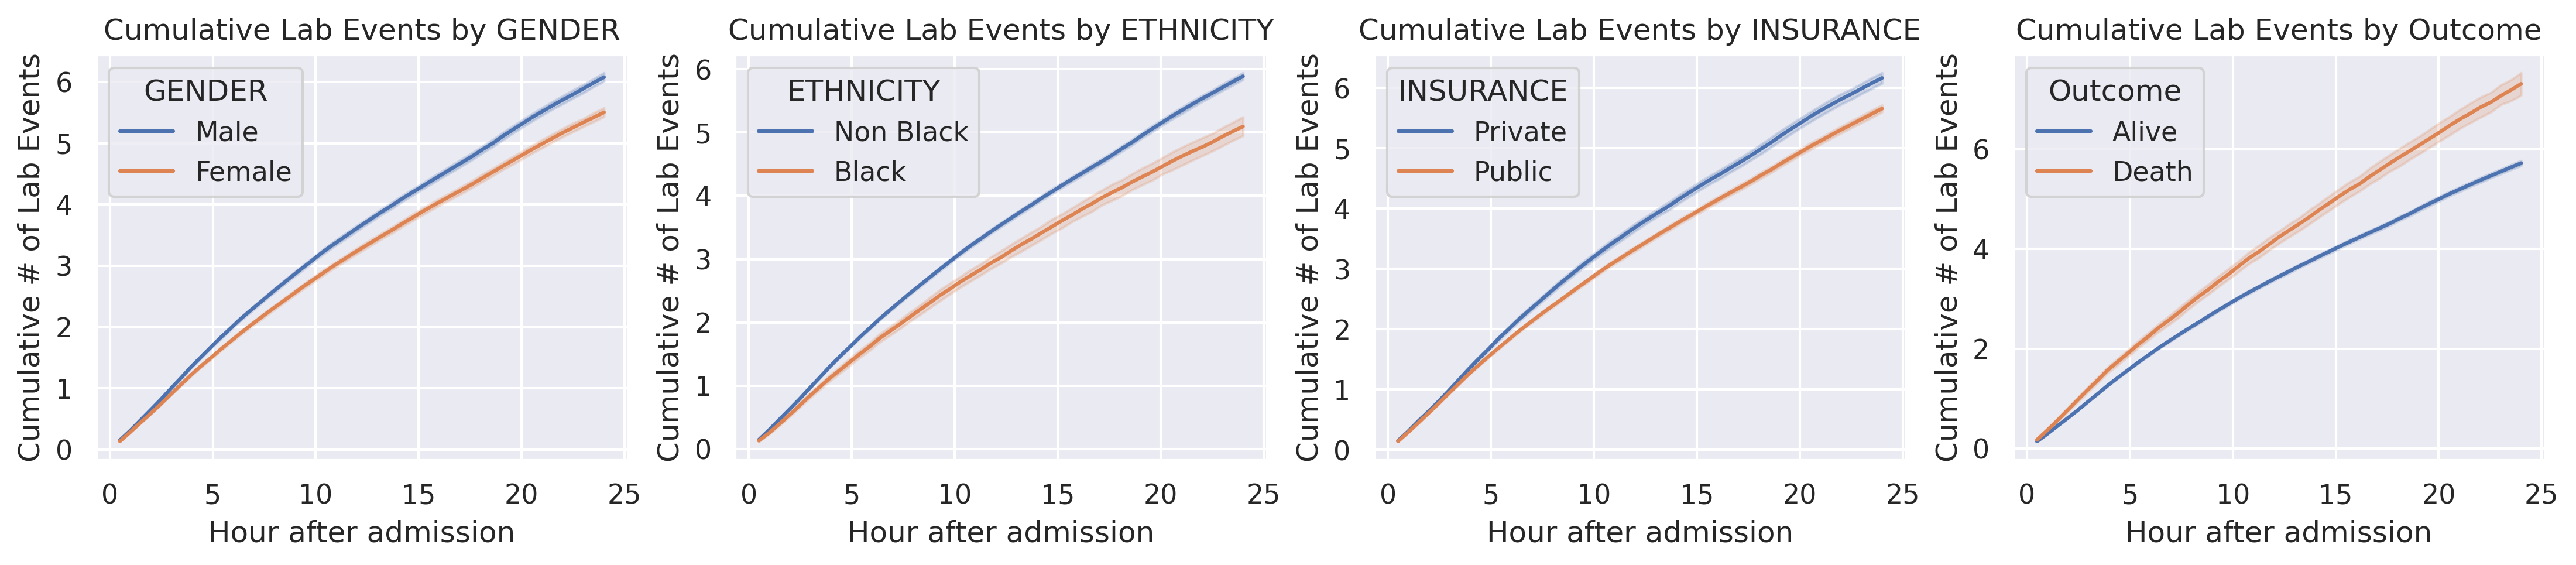

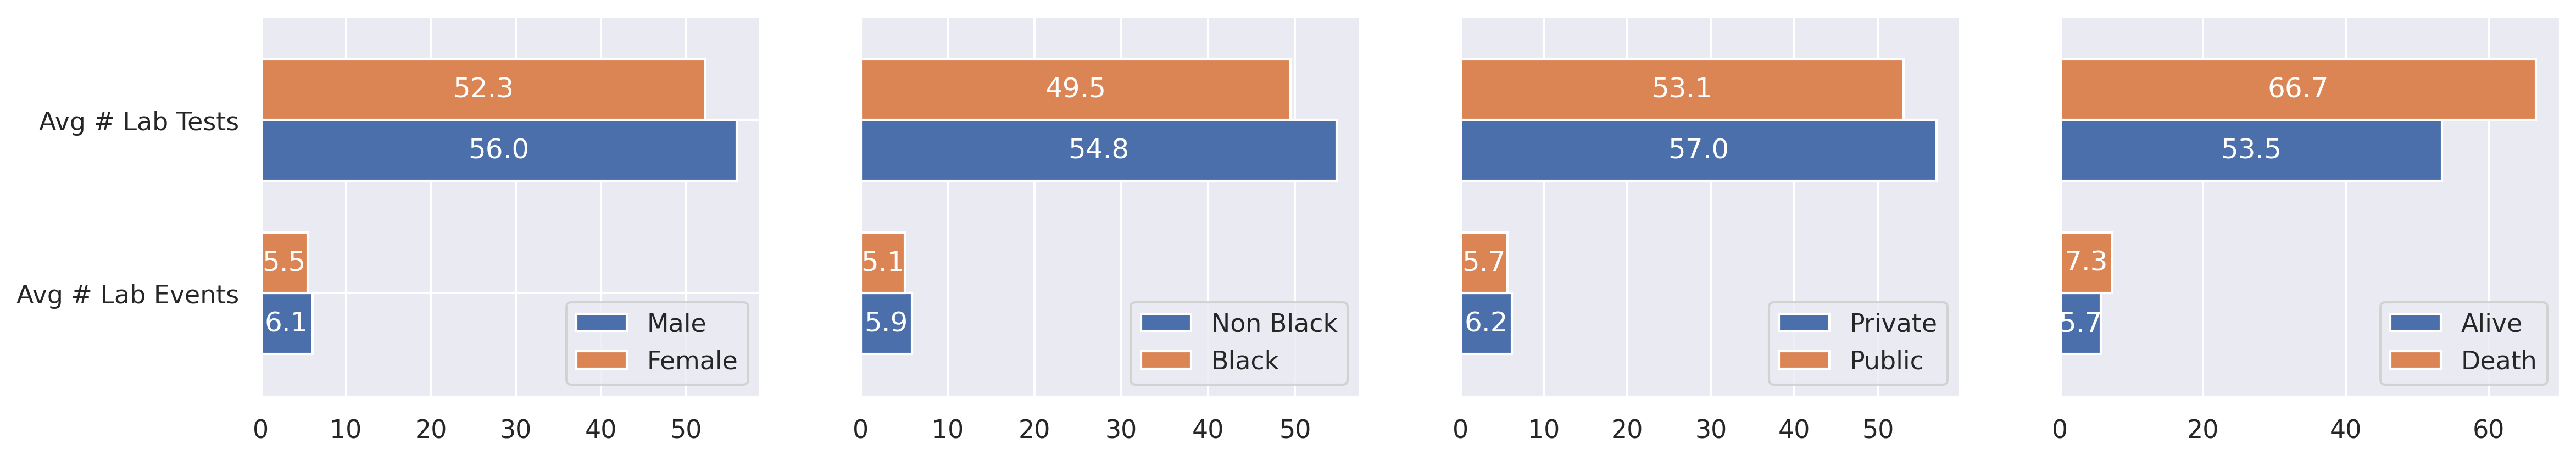

In [6]:
displayDatasetStatisticsPlots(labs, outcomes, demographics, dataset_stats)

plt.show()

#### Claim 2: Imputation methods that perform equally at the population level may perform differently for specific groups.
For example, MICE and Group MICE have similar overall AUC scores at the population level. However, MICE improves performance for Black patients, while Group MICE worsens it.

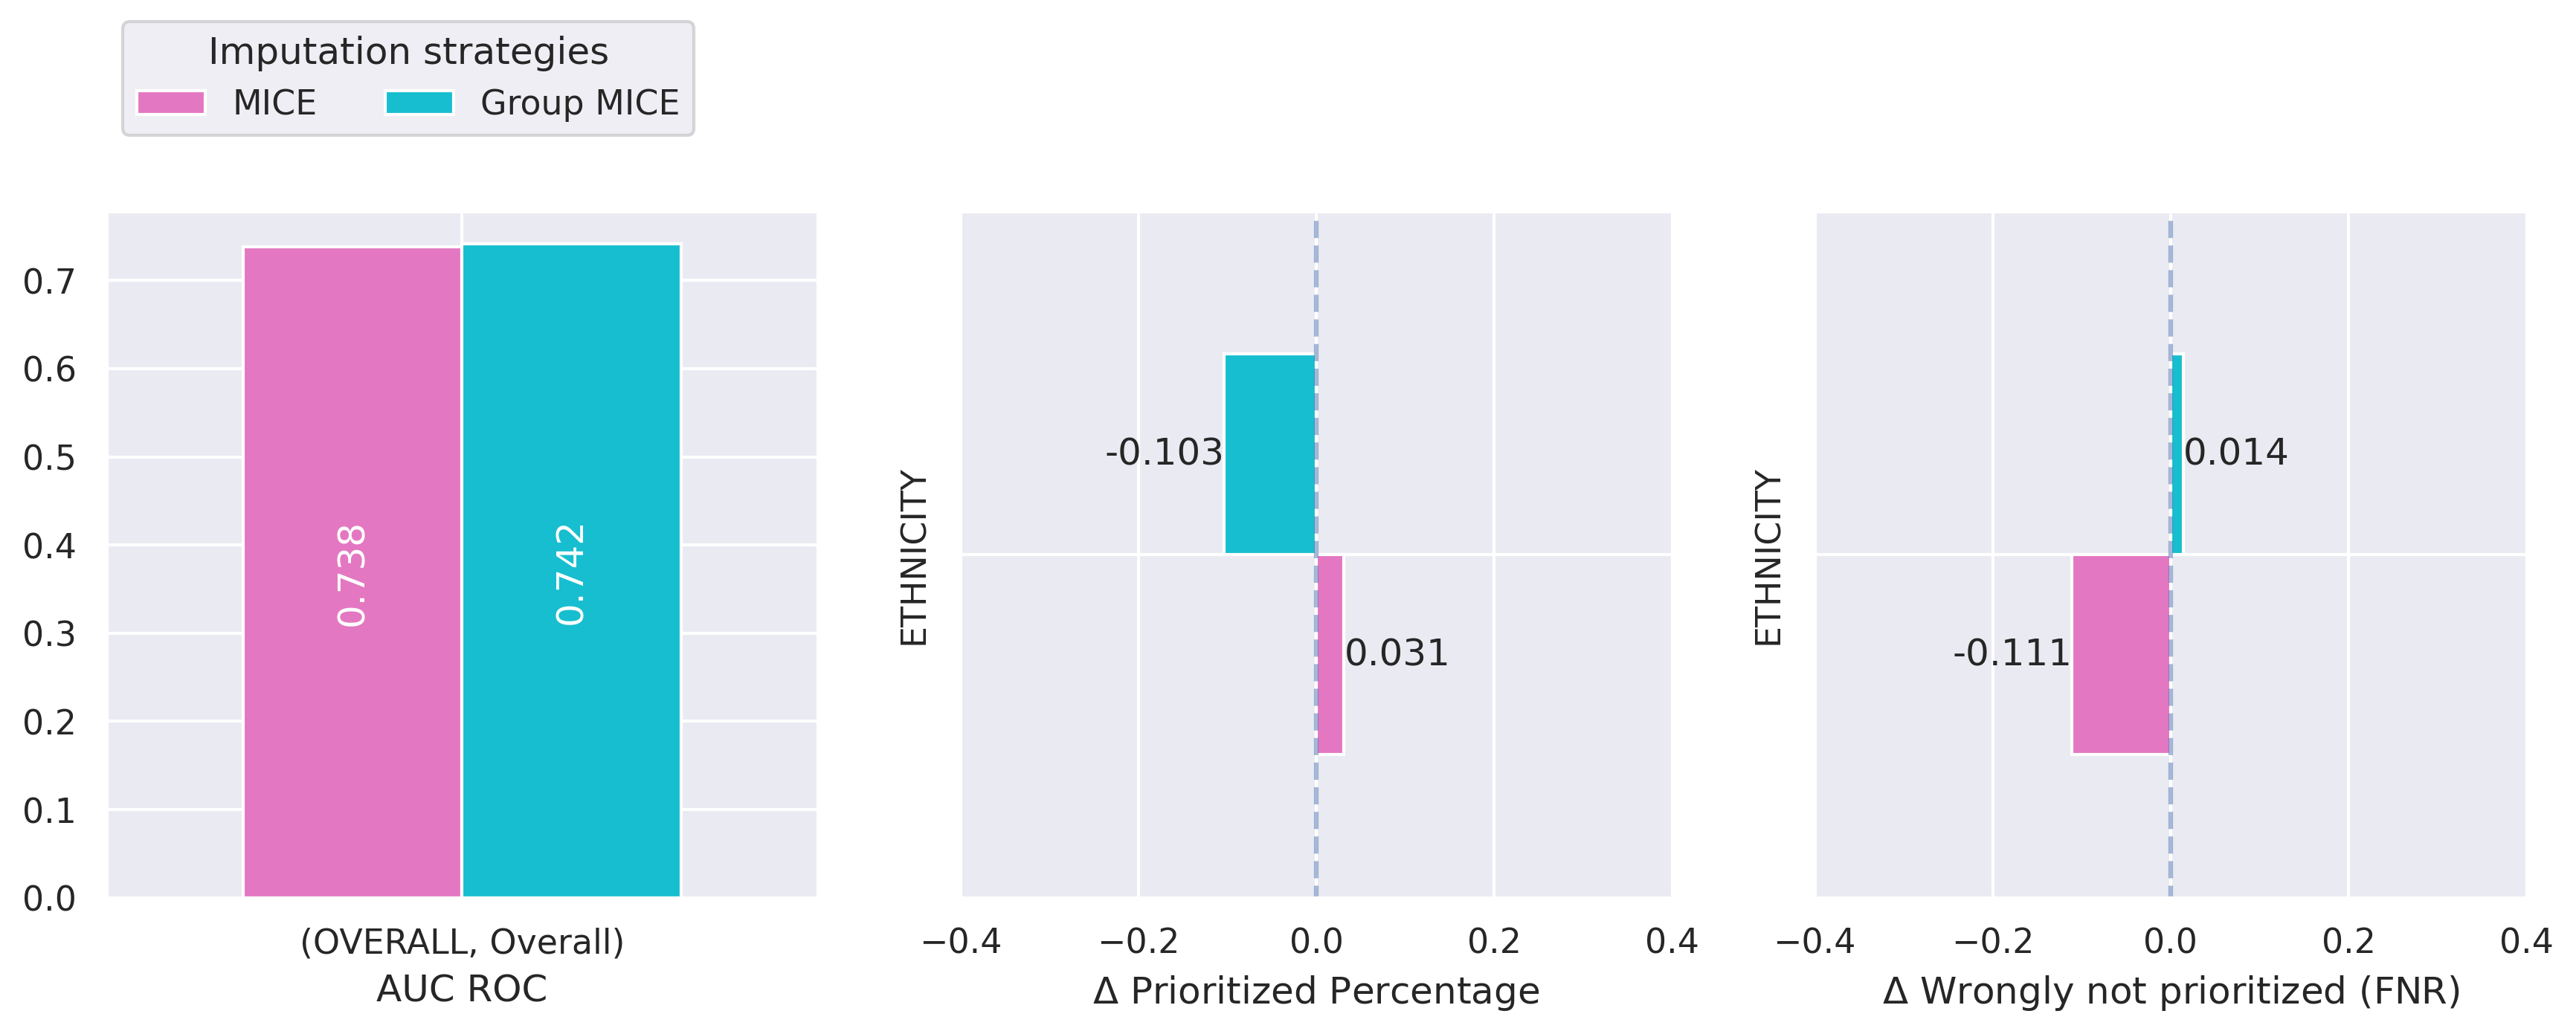

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

displayPopulationMetrics(
    'AUC ROC', 
    all_average_metrics, 
    strategies = ['MICE', 'Group MICE'], 
    populations = ['OVERALL'], 
    strategy_colors = ['tab:pink', 'tab:cyan'],
    ax = ax1)
displayMinorityMajorityComparison(
    'Prioritized Percentage',
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    ax = ax2, 
    showLegend = False)
displayMinorityMajorityComparison(
    'Wrongly not prioritized (FNR)',
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    ax = ax3, 
    showLegend = False)

plt.show()

#### Claim 3: There is no one “best” imputation strategy for all populations and all missingness scenarios.
For example, while the Median and MICE strategies resulted in higher FNRs for women, those two strategies also lowered the FNR for publicly insured patients.

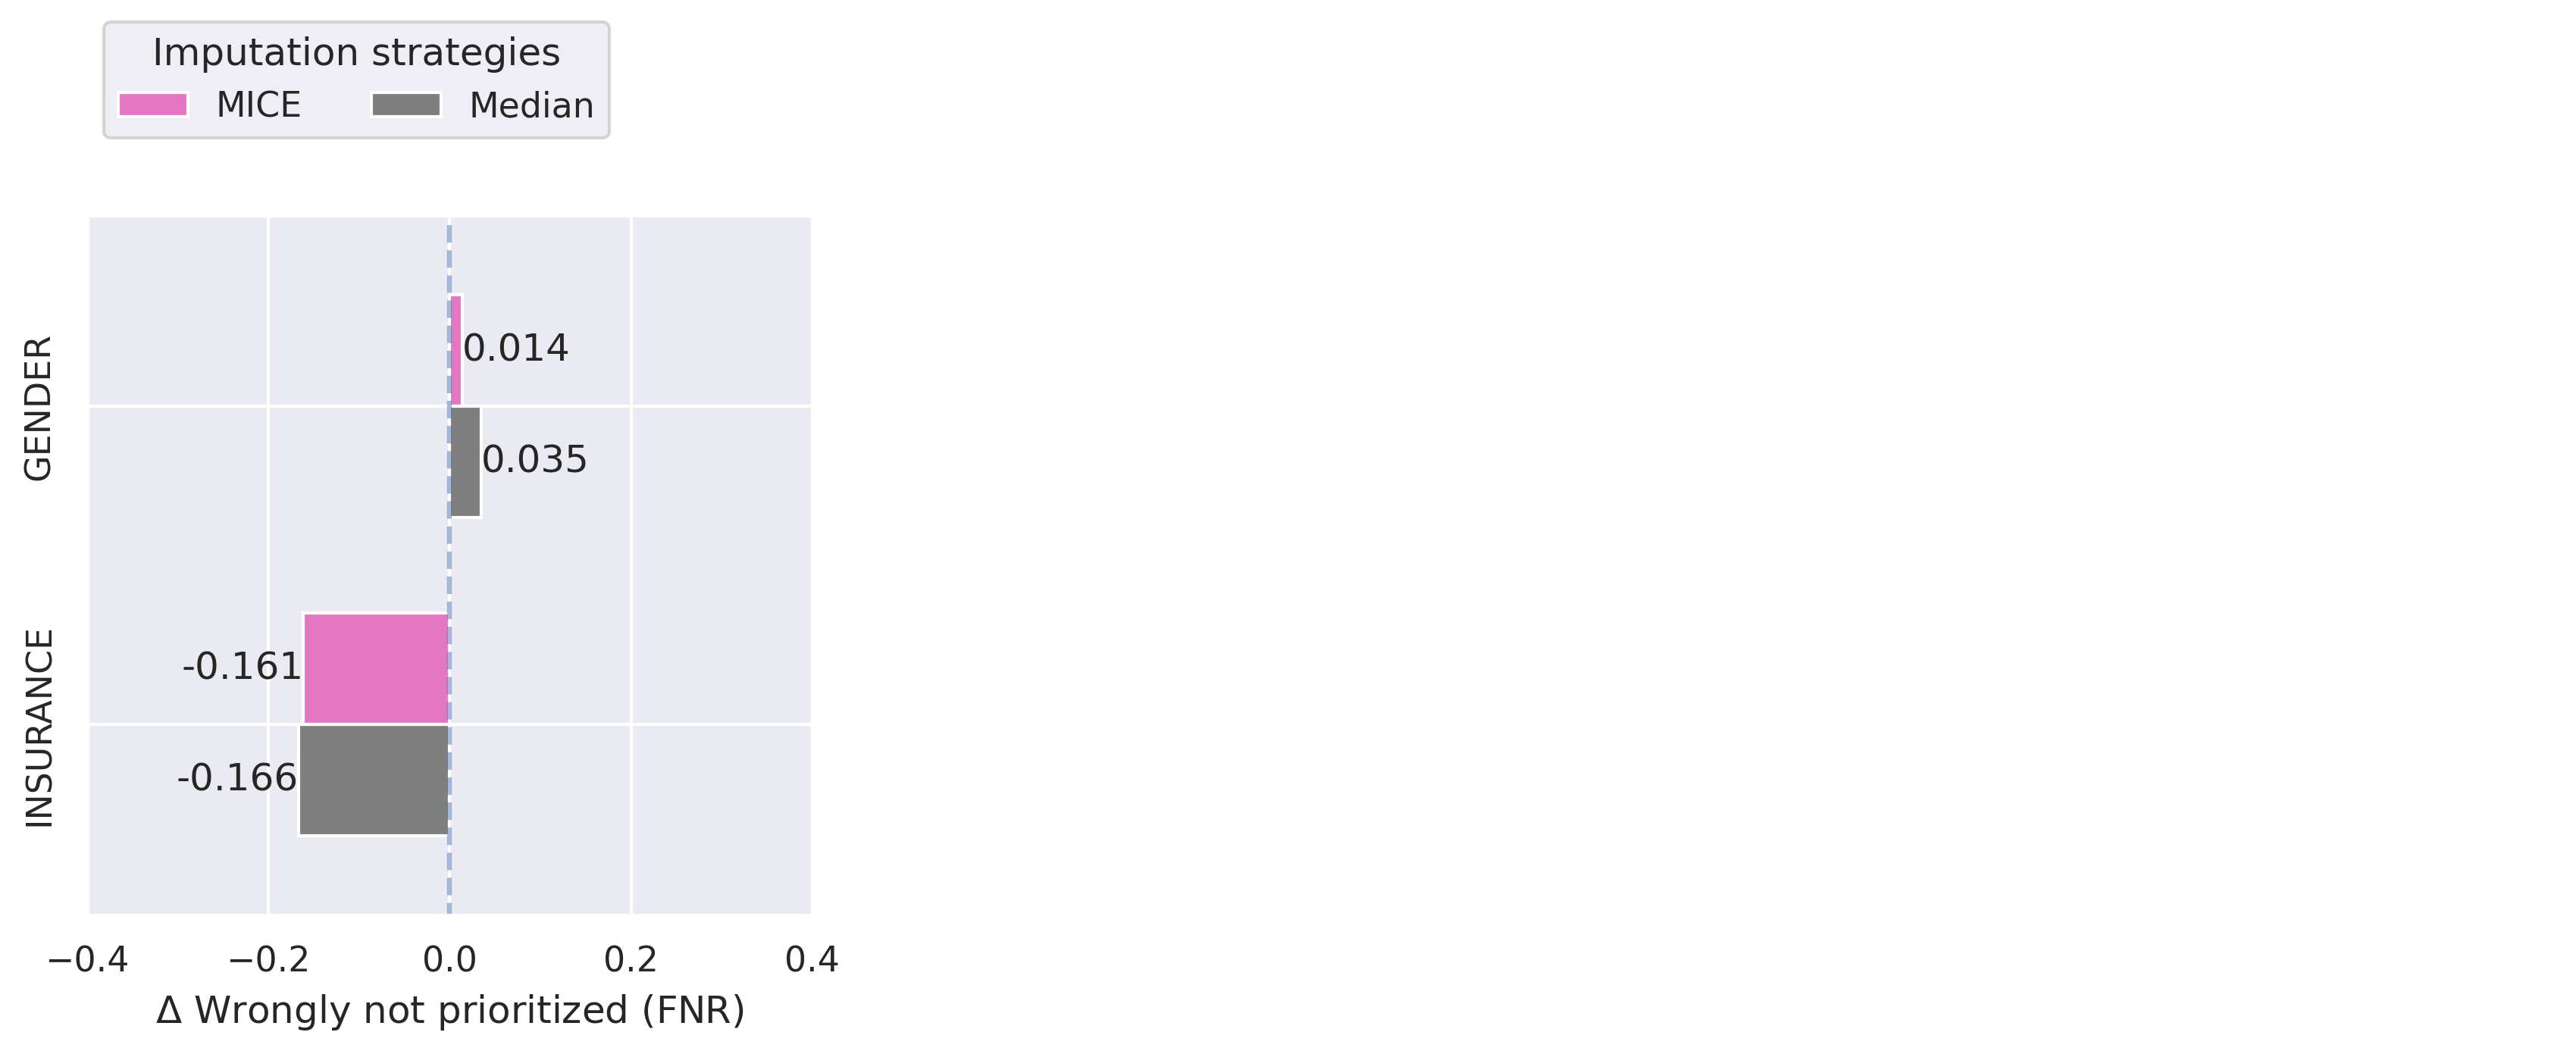

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

displayMinorityMajorityComparison(
    'Wrongly not prioritized (FNR)',
    all_gap_metrics, 
    strategies = ['MICE', 'Median'], 
    populations = ['GENDER', 'INSURANCE'], 
    strategy_colors = ['tab:pink', 'tab:gray'],
    ax = ax1)

ax2.axis('off')
ax3.axis('off')
plt.show()

#### Claim 4: Adding covariates or missingness indicators does not always improve performance.
For example, while MICE improves performance for Black patients, Group MICE worsens it.

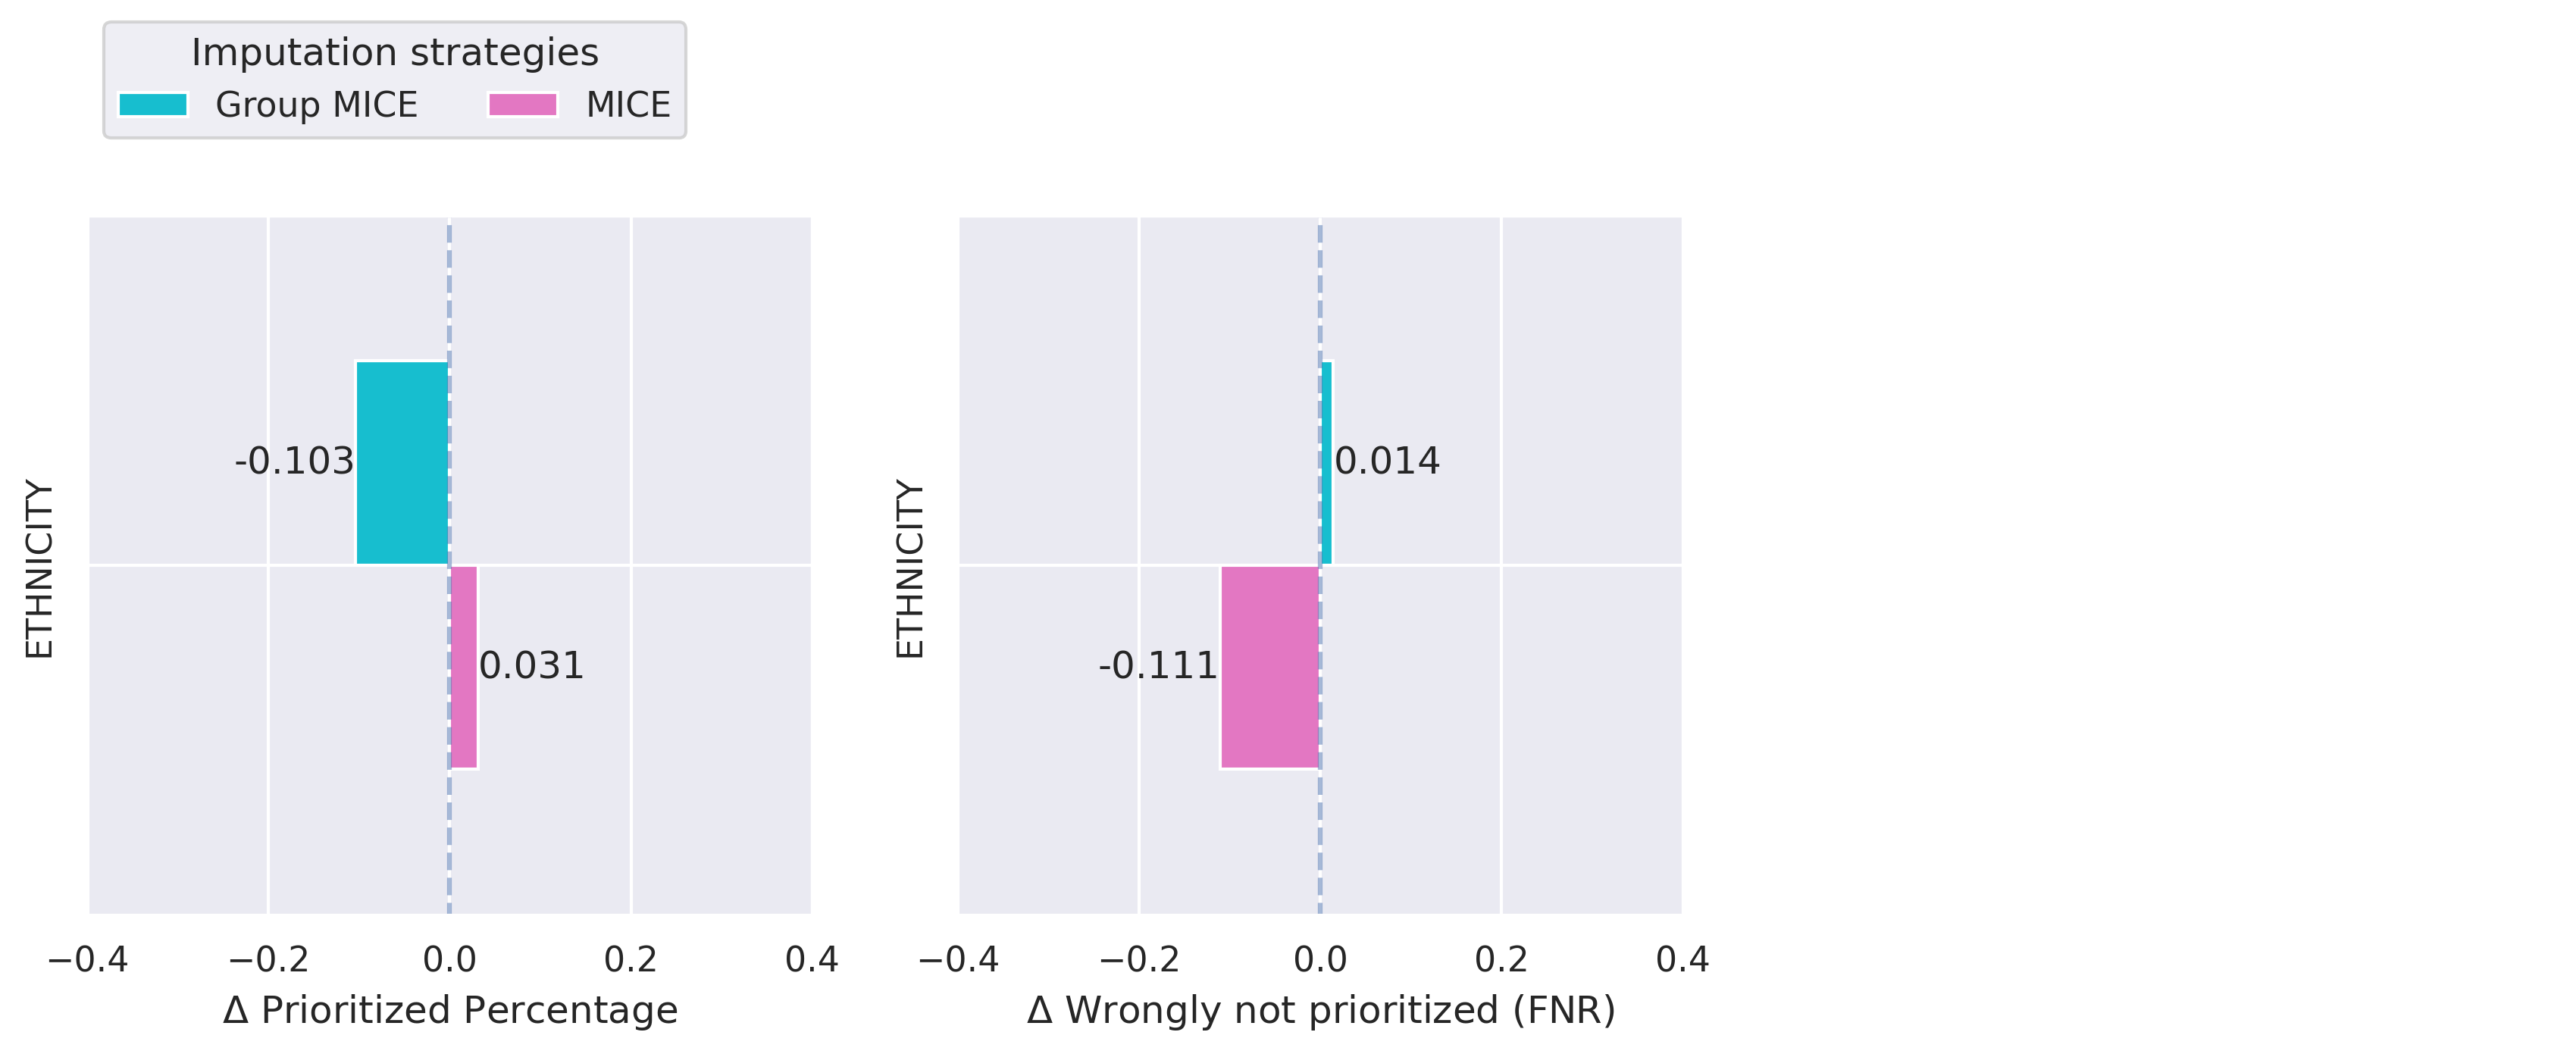

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

displayMinorityMajorityComparison(
    'Prioritized Percentage',
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    ax = ax1)
displayMinorityMajorityComparison(
    'Wrongly not prioritized (FNR)',
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    ax = ax2, 
    showLegend = False)

ax3.axis('off')
plt.show()

### Additional Experiments
In addition to reproducing the paper’s results, I did an ablation study where I removed the regularization component. I also tried replacing the logistic regression model with an MLP Classifier.

#### Running the Experiments
To see the results of these experiments, rerun the Experiment section above, changing the arguments given to the experiment method as follows:

To conduct the ablation study where regularization is removed, change the `regularization` argument:

`experiment(imputation_iterations, hyperparameters, regularization = False, model_name = 'logistic_regression')`

To conduct the experiment where the logistic regression is replaced with an MLP Classifier, change the `model_name` argument:

`experiment(imputation_iterations, hyperparameters, regularization = True, model_name = 'mlp_classifier')`

Then, rerun the Analysis section to see the results.

#### Results of the Experiments
Both of these experiments did not have much impact on the results. The changes in AUC score, prioritized percentage, and FNR were minimal. The same imputation strategies that benefited or hurt a minority population still benefited or hurt the same minority population with only a few exceptions: 1) when using MICE without regularization, the FNR for females is lower than for males; 2) for Group MICE Missing, the AUC score is worse for Black patients than for non Black patients when using the MLP Classifier; and 3) for Median, MICE, and Group MICE, the AUC score is lower for publicly versus privately insured patients when using the MLP Classifier.

Since these experiments appear to have limited impact on our results, this implies that the effects of applying the imputation strategies are robust and will likely carry over to more complex models. Thus, these experimental results further support the four hypotheses discussed.

### References
[1] Jeanselme, V., De-Arteaga, M., Zhang, Z., Barrett, J., & Tom, B. (2022, November). Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness. In _Machine Learning for Health_ (pp. 12-34). PMLR.

[2] Johnson, A. E., Pollard, T. J., Shen, L., Lehman, L. W. H., Feng, M., Ghassemi, M., ... & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. _Scientific data_, 3(1), 1-9.

[3] Wang, S., McDermott, M. B., Chauhan, G., Ghassemi, M., Hughes, M. C., & Naumann, T. (2020, April). Mimic-extract: A data extraction, preprocessing, and representation pipeline for mimic-iii. In _Proceedings of the ACM conference on health, inference, and learning_ (pp. 222-235).

[4] Nick, T. G., & Campbell, K. M. (2007). Logistic regression. _Topics in biostatistics_, 273-301.